# 로컬 예측 모델

In [1]:
from glob import glob
import pandas as pd
import numpy as np 
from tqdm.auto import tqdm
import cv2
import pickle
import warnings
warnings.filterwarnings('ignore')

import os
import timm
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.transforms as transforms
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
import time
import albumentations as albu
from albumentations.pytorch import ToTensorV2

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances
from lightgbm import LGBMClassifier

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
all_img_path = np.array(sorted(glob('../data/train/*.png')))
test_img_path = np.array(sorted(glob('../data/test/*.png')))

In [3]:
train_y = pd.read_csv("../data/train_df.csv")

train_classes = train_y["class"]

class_unique = sorted(np.unique(train_classes))
class_unique = {key:value for key,value in zip(class_unique, range(len(class_unique)))}
class_decoder = {val:key for key, val in class_unique.items()}

all_classes = np.array([class_unique[k] for k in train_classes])

In [4]:
train_y = pd.read_csv("../data/train_df.csv")

train_labels = train_y["label"]

label_unique = sorted(np.unique(train_labels))
label_unique = {key:value for key,value in zip(label_unique, range(len(label_unique)))}

all_label = np.array([label_unique[k] for k in train_labels])

In [5]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (128, 128)).flatten()
    return img

train_imgs = np.array([img_load(m) for m in tqdm(all_img_path)])
test_imgs = np.array([img_load(n) for n in tqdm(test_img_path[:300])])

train_imgs = train_imgs / 255
test_imgs = test_imgs / 255

  0%|          | 0/4277 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [6]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':4,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':8,
    'SEED':42
}

rows_train = len(train_imgs) # 주어진 train data의 row 수
rows_test = len(test_imgs) # 주어진 test data의 row 수
# rows_train = len(all_img_path) # 주어진 train data의 row 수
# rows_test = len(test_img_path) # 주어진 test data의 row 수
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 3 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 4 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수
num_classes = 88

pred_dict = {}
pred_test_dict = {}

In [7]:
all_label = pd.Series(all_label).astype('category')

In [8]:
def custom_metric(truth, predictions):
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": basic_seed,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
#         "device": "gpu",
        "num_class": num_classes,
        "learning_rate": trial.suggest_uniform("learning_rate", 8e-2, 1e-1), # default=0.1, range=[0,1]
        "max_depth": trial.suggest_int("max_depth", 3, 6), # default=-1
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-2, 1e+1), # default=0
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-2, 1e+1), # default=0
        "num_leaves": trial.suggest_int("num_leaves", 31, 1000), # default=31, range=(1,130172]
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction, default=1
        "subsample": trial.suggest_uniform("subsample", 0.5, 1.0), # bagging_fraction, default=1, range=[0,1]
        "subsample_freq": trial.suggest_int("subsample_freq", 10, 20), # bagging_freq, default=0
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 40), # min_data_in_leaf, default=20 
#         "max_bin": trial.suggest_int("max_bin", 100, 400),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle=True)
    cv = np.zeros((rows_train, num_classes))

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, all_label)):

        x_train, x_val = train_imgs[train_idx], train_imgs[val_idx]
        y_train, y_val = all_label[train_idx], all_label[val_idx]

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=30, eval_metric=custom_metric) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
#         print('fold', n+1, 'f1_score:', score_function(y_val, cv[val_idx, :].argmax(1)))
        
#     print('f1_score:', score_function(all_label, np.argmax(cv, axis=1)))
    return score_function(all_label, np.argmax(cv, axis=1))

In [9]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000, "num_class": num_classes, 
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

[I 2022-04-24 20:35:34,324] A new study created in memory with name: lgb_parameter_opt


[30]	valid_0's multi_logloss: 1.7604	valid_0's macroF1: 0.146037
[60]	valid_0's multi_logloss: 1.4716	valid_0's macroF1: 0.149296
[90]	valid_0's multi_logloss: 1.37661	valid_0's macroF1: 0.149759
[120]	valid_0's multi_logloss: 1.32707	valid_0's macroF1: 0.149708
[150]	valid_0's multi_logloss: 1.29391	valid_0's macroF1: 0.151251
[180]	valid_0's multi_logloss: 1.25996	valid_0's macroF1: 0.151245
[210]	valid_0's multi_logloss: 1.2299	valid_0's macroF1: 0.156388
[240]	valid_0's multi_logloss: 1.20613	valid_0's macroF1: 0.156561
[270]	valid_0's multi_logloss: 1.18619	valid_0's macroF1: 0.156615
[300]	valid_0's multi_logloss: 1.17677	valid_0's macroF1: 0.15665
[330]	valid_0's multi_logloss: 1.16418	valid_0's macroF1: 0.156748
[360]	valid_0's multi_logloss: 1.14721	valid_0's macroF1: 0.156771
[390]	valid_0's multi_logloss: 1.13465	valid_0's macroF1: 0.156818
[420]	valid_0's multi_logloss: 1.12791	valid_0's macroF1: 0.157012
[450]	valid_0's multi_logloss: 1.1091	valid_0's macroF1: 0.156918
[48

[I 2022-04-24 22:02:56,133] Trial 0 finished with value: 0.1796601734974743 and parameters: {'learning_rate': 0.04370861069626263, 'max_depth': 8, 'reg_alpha': 1.5702970884055387, 'reg_lambda': 0.6251373574521749, 'num_leaves': 338, 'colsample_bytree': 0.32479561626896214, 'subsample': 0.24646688973455957, 'subsample_freq': 18, 'min_child_samples': 25}. Best is trial 0 with value: 0.1796601734974743.


[30]	valid_0's multi_logloss: 2.18982	valid_0's macroF1: 0.147963
[60]	valid_0's multi_logloss: 1.97956	valid_0's macroF1: 0.149868
[90]	valid_0's multi_logloss: 1.85667	valid_0's macroF1: 0.15091
[120]	valid_0's multi_logloss: 1.7762	valid_0's macroF1: 0.151239
[150]	valid_0's multi_logloss: 1.72657	valid_0's macroF1: 0.151401
[180]	valid_0's multi_logloss: 1.68266	valid_0's macroF1: 0.150831
[210]	valid_0's multi_logloss: 1.65782	valid_0's macroF1: 0.151487
[240]	valid_0's multi_logloss: 1.63869	valid_0's macroF1: 0.151355
[270]	valid_0's multi_logloss: 1.62644	valid_0's macroF1: 0.151389
[300]	valid_0's multi_logloss: 1.61113	valid_0's macroF1: 0.151286
[330]	valid_0's multi_logloss: 1.60416	valid_0's macroF1: 0.151827
[360]	valid_0's multi_logloss: 1.59561	valid_0's macroF1: 0.151023
[390]	valid_0's multi_logloss: 1.58974	valid_0's macroF1: 0.150919
[420]	valid_0's multi_logloss: 1.5864	valid_0's macroF1: 0.150941
[450]	valid_0's multi_logloss: 1.58406	valid_0's macroF1: 0.150577
[

[I 2022-04-24 22:58:09,852] Trial 1 finished with value: 0.1509449891563289 and parameters: {'learning_rate': 0.0737265320016441, 'max_depth': 4, 'reg_alpha': 8.123245085588687, 'reg_lambda': 3.142880890840109, 'num_leaves': 449, 'colsample_bytree': 0.3454599737656805, 'subsample': 0.34672360788274703, 'subsample_freq': 7, 'min_child_samples': 21}. Best is trial 0 with value: 0.1796601734974743.


[30]	valid_0's multi_logloss: 1.23067	valid_0's macroF1: 0.181161
[60]	valid_0's multi_logloss: 1.06647	valid_0's macroF1: 0.182848
[90]	valid_0's multi_logloss: 1.03076	valid_0's macroF1: 0.175532
[120]	valid_0's multi_logloss: 1.01519	valid_0's macroF1: 0.179785
[150]	valid_0's multi_logloss: 1.01034	valid_0's macroF1: 0.179203
[180]	valid_0's multi_logloss: 1.00612	valid_0's macroF1: 0.179332
[210]	valid_0's multi_logloss: 1.00218	valid_0's macroF1: 0.179317
[30]	valid_0's multi_logloss: 1.23453	valid_0's macroF1: 0.164607
[60]	valid_0's multi_logloss: 1.08143	valid_0's macroF1: 0.172983
[90]	valid_0's multi_logloss: 1.04328	valid_0's macroF1: 0.177443
[120]	valid_0's multi_logloss: 1.03153	valid_0's macroF1: 0.182789
[150]	valid_0's multi_logloss: 1.02085	valid_0's macroF1: 0.18369
[180]	valid_0's multi_logloss: 1.02133	valid_0's macroF1: 0.187144
[210]	valid_0's multi_logloss: 1.0219	valid_0's macroF1: 0.187481
[240]	valid_0's multi_logloss: 1.02028	valid_0's macroF1: 0.187481
[27

[I 2022-04-25 00:23:25,935] Trial 2 finished with value: 0.19540445334060416 and parameters: {'learning_rate': 0.048875051677790424, 'max_depth': 5, 'reg_alpha': 0.6847920095574779, 'reg_lambda': 0.02621087878265441, 'num_leaves': 606, 'colsample_bytree': 0.4930894746349534, 'subsample': 0.5648559873736287, 'subsample_freq': 16, 'min_child_samples': 8}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 1.06695	valid_0's macroF1: 0.1574
[60]	valid_0's multi_logloss: 0.962378	valid_0's macroF1: 0.158902
[90]	valid_0's multi_logloss: 0.961117	valid_0's macroF1: 0.15908
[120]	valid_0's multi_logloss: 0.96657	valid_0's macroF1: 0.159716
[150]	valid_0's multi_logloss: 0.973489	valid_0's macroF1: 0.163444
[180]	valid_0's multi_logloss: 0.980821	valid_0's macroF1: 0.169168
[210]	valid_0's multi_logloss: 0.987758	valid_0's macroF1: 0.172393
[240]	valid_0's multi_logloss: 0.993982	valid_0's macroF1: 0.172318
[270]	valid_0's multi_logloss: 0.99954	valid_0's macroF1: 0.172577
[30]	valid_0's multi_logloss: 1.05351	valid_0's macroF1: 0.158269
[60]	valid_0's multi_logloss: 0.942955	valid_0's macroF1: 0.164832
[90]	valid_0's multi_logloss: 0.937804	valid_0's macroF1: 0.188365
[120]	valid_0's multi_logloss: 0.94503	valid_0's macroF1: 0.188595
[150]	valid_0's multi_logloss: 0.950515	valid_0's macroF1: 0.188597
[180]	valid_0's multi_logloss: 0.95781	valid_0's macroF1: 0.19

[I 2022-04-25 01:34:01,117] Trial 3 finished with value: 0.1811437033884162 and parameters: {'learning_rate': 0.05628109945722505, 'max_depth': 6, 'reg_alpha': 0.013783237455007183, 'reg_lambda': 0.6647135865318028, 'num_leaves': 366, 'colsample_bytree': 0.25204127438822366, 'subsample': 0.9591084298026666, 'subsample_freq': 20, 'min_child_samples': 33}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 1.69808	valid_0's macroF1: 0.144797
[60]	valid_0's multi_logloss: 1.3846	valid_0's macroF1: 0.148264
[90]	valid_0's multi_logloss: 1.28734	valid_0's macroF1: 0.149457
[120]	valid_0's multi_logloss: 1.24445	valid_0's macroF1: 0.14975
[150]	valid_0's multi_logloss: 1.21676	valid_0's macroF1: 0.15452
[180]	valid_0's multi_logloss: 1.18529	valid_0's macroF1: 0.162021
[210]	valid_0's multi_logloss: 1.17253	valid_0's macroF1: 0.15538
[240]	valid_0's multi_logloss: 1.1615	valid_0's macroF1: 0.16946
[270]	valid_0's multi_logloss: 1.15256	valid_0's macroF1: 0.169296
[300]	valid_0's multi_logloss: 1.14779	valid_0's macroF1: 0.170978
[330]	valid_0's multi_logloss: 1.14495	valid_0's macroF1: 0.17236
[360]	valid_0's multi_logloss: 1.14066	valid_0's macroF1: 0.17249
[390]	valid_0's multi_logloss: 1.1366	valid_0's macroF1: 0.170015
[420]	valid_0's multi_logloss: 1.13363	valid_0's macroF1: 0.170232
[450]	valid_0's multi_logloss: 1.13484	valid_0's macroF1: 0.170497
[30]	va

[I 2022-04-25 03:38:26,372] Trial 4 finished with value: 0.1813509509913958 and parameters: {'learning_rate': 0.037415239225603365, 'max_depth': 4, 'reg_alpha': 1.1290133559092674, 'reg_lambda': 0.2091498132903561, 'num_leaves': 271, 'colsample_bytree': 0.5961415280890161, 'subsample': 0.22751081689217473, 'subsample_freq': 19, 'min_child_samples': 11}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 1.04416	valid_0's macroF1: 0.159225
[60]	valid_0's multi_logloss: 0.958212	valid_0's macroF1: 0.170049
[90]	valid_0's multi_logloss: 0.936831	valid_0's macroF1: 0.170559
[120]	valid_0's multi_logloss: 0.932919	valid_0's macroF1: 0.184113
[150]	valid_0's multi_logloss: 0.932079	valid_0's macroF1: 0.183917
[180]	valid_0's multi_logloss: 0.931805	valid_0's macroF1: 0.183766
[210]	valid_0's multi_logloss: 0.932697	valid_0's macroF1: 0.1839
[240]	valid_0's multi_logloss: 0.932549	valid_0's macroF1: 0.183905
[270]	valid_0's multi_logloss: 0.932219	valid_0's macroF1: 0.183784
[300]	valid_0's multi_logloss: 0.933323	valid_0's macroF1: 0.184255
[330]	valid_0's multi_logloss: 0.933467	valid_0's macroF1: 0.183987
[30]	valid_0's multi_logloss: 1.05531	valid_0's macroF1: 0.160592
[60]	valid_0's multi_logloss: 0.969447	valid_0's macroF1: 0.187735
[90]	valid_0's multi_logloss: 0.948631	valid_0's macroF1: 0.190167
[120]	valid_0's multi_logloss: 0.94592	valid_0's macroF1: 

[I 2022-04-25 06:04:24,116] Trial 5 finished with value: 0.19530962579897782 and parameters: {'learning_rate': 0.06962700559185839, 'max_depth': 5, 'reg_alpha': 0.3632486956676606, 'reg_lambda': 0.43664735929796333, 'num_leaves': 395, 'colsample_bytree': 0.9756677022116469, 'subsample': 0.8201062586888916, 'subsample_freq': 19, 'min_child_samples': 36}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 1.15041	valid_0's macroF1: 0.150897
[60]	valid_0's multi_logloss: 1.14849	valid_0's macroF1: 0.15761
[90]	valid_0's multi_logloss: 1.16442	valid_0's macroF1: 0.158567
[120]	valid_0's multi_logloss: 1.15824	valid_0's macroF1: 0.158431
[150]	valid_0's multi_logloss: 1.15388	valid_0's macroF1: 0.164358
[180]	valid_0's multi_logloss: 1.15713	valid_0's macroF1: 0.167446
[210]	valid_0's multi_logloss: 1.16219	valid_0's macroF1: 0.164301
[240]	valid_0's multi_logloss: 1.18704	valid_0's macroF1: 0.164574
[30]	valid_0's multi_logloss: 1.14437	valid_0's macroF1: 0.164464
[60]	valid_0's multi_logloss: 1.1262	valid_0's macroF1: 0.167519
[90]	valid_0's multi_logloss: 1.13574	valid_0's macroF1: 0.174502
[120]	valid_0's multi_logloss: 1.12568	valid_0's macroF1: 0.178424
[150]	valid_0's multi_logloss: 1.10913	valid_0's macroF1: 0.188272
[180]	valid_0's multi_logloss: 1.10632	valid_0's macroF1: 0.196196
[210]	valid_0's multi_logloss: 1.10566	valid_0's macroF1: 0.196012
[24

[I 2022-04-25 07:14:17,988] Trial 6 finished with value: 0.17164515479626774 and parameters: {'learning_rate': 0.06381099809299767, 'max_depth': 8, 'reg_alpha': 0.01842797040686454, 'reg_lambda': 0.03872118032174583, 'num_leaves': 120, 'colsample_bytree': 0.4602642646106115, 'subsample': 0.5109418317515857, 'subsample_freq': 6, 'min_child_samples': 34}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 1.23381	valid_0's macroF1: 0.164072
[60]	valid_0's multi_logloss: 1.07027	valid_0's macroF1: 0.166557
[90]	valid_0's multi_logloss: 1.04363	valid_0's macroF1: 0.166847
[120]	valid_0's multi_logloss: 1.03931	valid_0's macroF1: 0.172935
[150]	valid_0's multi_logloss: 1.03424	valid_0's macroF1: 0.172683
[180]	valid_0's multi_logloss: 1.03225	valid_0's macroF1: 0.172683
[210]	valid_0's multi_logloss: 1.03188	valid_0's macroF1: 0.172683
[240]	valid_0's multi_logloss: 1.03169	valid_0's macroF1: 0.172683
[270]	valid_0's multi_logloss: 1.03159	valid_0's macroF1: 0.172683
[300]	valid_0's multi_logloss: 1.03157	valid_0's macroF1: 0.172683
[30]	valid_0's multi_logloss: 1.20623	valid_0's macroF1: 0.1864
[60]	valid_0's multi_logloss: 1.04588	valid_0's macroF1: 0.179387
[90]	valid_0's multi_logloss: 1.02226	valid_0's macroF1: 0.180907
[120]	valid_0's multi_logloss: 1.01829	valid_0's macroF1: 0.180939
[150]	valid_0's multi_logloss: 1.01232	valid_0's macroF1: 0.18102
[180

[I 2022-04-25 07:59:24,500] Trial 7 finished with value: 0.18979899168268946 and parameters: {'learning_rate': 0.04210779940242304, 'max_depth': 5, 'reg_alpha': 0.4247058562261869, 'reg_lambda': 0.02647114182821816, 'num_leaves': 1611, 'colsample_bytree': 0.2596405149438167, 'subsample': 0.9895095492804138, 'subsample_freq': 16, 'min_child_samples': 8}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 2.19579	valid_0's macroF1: 0.148141
[60]	valid_0's multi_logloss: 1.75731	valid_0's macroF1: 0.151077
[90]	valid_0's multi_logloss: 1.51852	valid_0's macroF1: 0.151967
[120]	valid_0's multi_logloss: 1.36756	valid_0's macroF1: 0.153296
[150]	valid_0's multi_logloss: 1.26644	valid_0's macroF1: 0.154052
[180]	valid_0's multi_logloss: 1.19533	valid_0's macroF1: 0.154054
[210]	valid_0's multi_logloss: 1.14256	valid_0's macroF1: 0.154307
[240]	valid_0's multi_logloss: 1.10294	valid_0's macroF1: 0.154444
[270]	valid_0's multi_logloss: 1.0707	valid_0's macroF1: 0.154575
[300]	valid_0's multi_logloss: 1.04529	valid_0's macroF1: 0.154435
[330]	valid_0's multi_logloss: 1.0239	valid_0's macroF1: 0.154429
[360]	valid_0's multi_logloss: 1.00574	valid_0's macroF1: 0.154681
[390]	valid_0's multi_logloss: 0.990964	valid_0's macroF1: 0.154547
[420]	valid_0's multi_logloss: 0.977689	valid_0's macroF1: 0.154821
[450]	valid_0's multi_logloss: 0.966877	valid_0's macroF1: 0.1546

[I 2022-04-25 10:21:11,774] Trial 8 finished with value: 0.16708131487232486 and parameters: {'learning_rate': 0.010496990541124216, 'max_depth': 8, 'reg_alpha': 1.3199942261535018, 'reg_lambda': 1.5382308040278996, 'num_leaves': 1550, 'colsample_bytree': 0.2592357213872723, 'subsample': 0.48677258283541813, 'subsample_freq': 3, 'min_child_samples': 35}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 1.13211	valid_0's macroF1: 0.155935
[60]	valid_0's multi_logloss: 1.11389	valid_0's macroF1: 0.161019
[90]	valid_0's multi_logloss: 1.11933	valid_0's macroF1: 0.161698
[120]	valid_0's multi_logloss: 1.12726	valid_0's macroF1: 0.166845
[150]	valid_0's multi_logloss: 1.12771	valid_0's macroF1: 0.172598
[180]	valid_0's multi_logloss: 1.1266	valid_0's macroF1: 0.18332
[210]	valid_0's multi_logloss: 1.13041	valid_0's macroF1: 0.183579
[240]	valid_0's multi_logloss: 1.12964	valid_0's macroF1: 0.183446
[30]	valid_0's multi_logloss: 1.16319	valid_0's macroF1: 0.150214
[60]	valid_0's multi_logloss: 1.14438	valid_0's macroF1: 0.157
[90]	valid_0's multi_logloss: 1.14023	valid_0's macroF1: 0.17905
[120]	valid_0's multi_logloss: 1.14101	valid_0's macroF1: 0.182331
[150]	valid_0's multi_logloss: 1.13813	valid_0's macroF1: 0.182425
[180]	valid_0's multi_logloss: 1.13721	valid_0's macroF1: 0.182777
[210]	valid_0's multi_logloss: 1.14099	valid_0's macroF1: 0.182972
[240]	v

[I 2022-04-25 12:42:32,652] Trial 9 finished with value: 0.1748768709868674 and parameters: {'learning_rate': 0.06609683141448022, 'max_depth': 5, 'reg_alpha': 0.015512259126484752, 'reg_lambda': 0.08569331925053984, 'num_leaves': 671, 'colsample_bytree': 0.7836849426704513, 'subsample': 0.7100459770841705, 'subsample_freq': 18, 'min_child_samples': 19}. Best is trial 2 with value: 0.19540445334060416.


[30]	valid_0's multi_logloss: 2.50138	valid_0's macroF1: 0.164958
[60]	valid_0's multi_logloss: 2.33157	valid_0's macroF1: 0.164867
[90]	valid_0's multi_logloss: 2.27692	valid_0's macroF1: 0.161169
[120]	valid_0's multi_logloss: 2.26797	valid_0's macroF1: 0.159244
[150]	valid_0's multi_logloss: 2.26554	valid_0's macroF1: 0.159327
[180]	valid_0's multi_logloss: 2.26202	valid_0's macroF1: 0.159611
[210]	valid_0's multi_logloss: 2.26021	valid_0's macroF1: 0.159851
[240]	valid_0's multi_logloss: 2.26012	valid_0's macroF1: 0.159705
[30]	valid_0's multi_logloss: 2.98111	valid_0's macroF1: 0.182265
[60]	valid_0's multi_logloss: 17.8534	valid_0's macroF1: 0.104732
[90]	valid_0's multi_logloss: 14.5851	valid_0's macroF1: 0.131626
[120]	valid_0's multi_logloss: 14.3284	valid_0's macroF1: 0.137645


KeyboardInterrupt: 

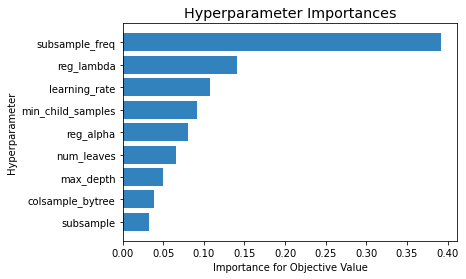

In [10]:
optuna.visualization.matplotlib.plot_param_importances(lgb_study);

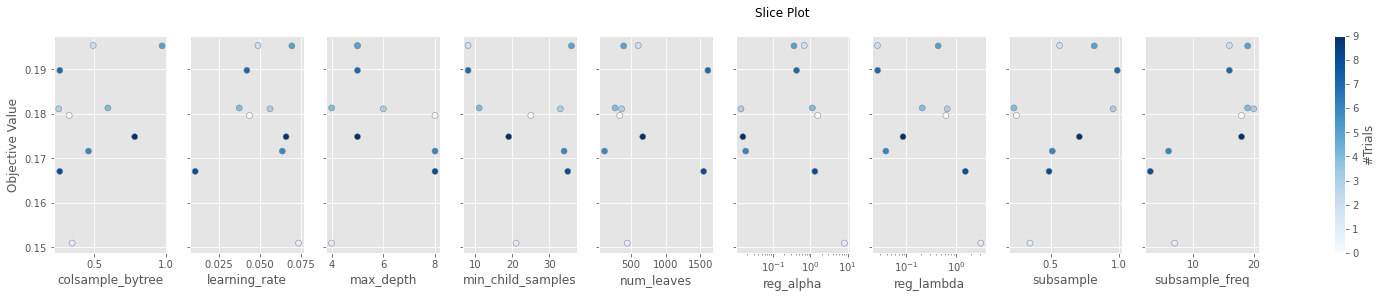

In [11]:
optuna.visualization.matplotlib.plot_slice(lgb_study);

In [ ]:
lgb_best_hyperparams = {'learning_rate': 0.03, 'num_leaves': 2**8+2**7, 'max_depth': 8}
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000, "num_class": num_classes}
lgb_best_hyperparams.update(lgb_base_hyperparams)

In [ ]:
# lucky_seeds = np.random.randint(0, 1000, num_seed)

for i, seed in enumerate([0]):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros((rows_train, num_classes))
    pred_test = np.zeros((rows_test, num_classes), dtype=float)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_imgs, all_label)):
        
        x_train, x_val = train_imgs[train_idx], train_imgs[val_idx]
        y_train, y_val = all_label[train_idx], all_label[val_idx]

        lgbmodel = LGBMClassifier(**lgb_best_hyperparams)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=1, eval_metric=custom_metric) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        pred_test += lgbmodel.predict_proba(test_x) / splits_tr
        
    pred_dict['lgb'+str(seed)] = cv
    pred_test_dict['lgb'+str(seed)] = pred_test
    print(f'seed {seed}', 'accuracy_score :', accuracy_score(train_y, np.argmax(cv, axis=1)))

In [ ]:
class LocalDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        img = cv2.imread(img_path)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_path_list)

In [ ]:
splits_tr = 4
num_classes = 15
basic_seed = 42
rows_train = len(all_img_path) # 주어진 train data의 row 수
rows_test = len(test_img_path) # 주어진 test data의 row 수

In [ ]:
def train_local(model, optimizer, train_loader, vali_loader, device):
    model.to(device)

    # Loss Function
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        train_pred=[]
        train_y=[]
        model.train()
        train_loss = 0
        for img, label in tqdm(iter(train_loader)):
            
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            label = label.to(torch.int64)
            loss = criterion(logit, label)

            # backpropagation
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()/len(train_loader)
            train_pred += logit.argmax(1).detach().cpu().numpy().tolist()
            train_y += label.detach().cpu().numpy().tolist()
            
        # Evaluation Validation set
        vali_score = validation_local(model, vali_loader, device)
        
        # vali_score가 더 이상 커지지 않으면
        if scheduler is not None:
            scheduler.step(vali_score)
        
        print(f'Epoch [{epoch}] Train Score : [{accuracy_score(train_y, train_pred):.5f}] Validation Score : [{vali_score:.5f}]\n')
        
        # Model Saved
        if best_score < vali_score:
            best_score = vali_score
            torch.save(model.state_dict(), '../model/local_model.pth')
            print('Model Saved.')

In [ ]:
def validation_local(model, vali_loader, device):
    model.eval() # Evaluation
    logit_list = []
    label_list = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)
            label = label.to(torch.int64)

            logit_list.extend(model(img).argmax(1).detach().cpu().numpy().tolist())
            label_list.extend(label.detach().cpu().numpy().tolist())

    vali_f1_score = accuracy_score(label_list, logit_list)
    return vali_f1_score

In [ ]:
def predict_local(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            
            img = img.float().to(device)

            pred_logit = model(img).detach().cpu()
            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        img = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image=img)["image"]

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_path_list)
    
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
train_transform = albu.Compose([
    albu.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    ToTensorV2()]
)

valid_transform = albu.Compose([
    albu.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    ToTensorV2()]
)

test_transform = albu.Compose([
    albu.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    ToTensorV2()]
)

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

kfold = KFold(n_splits=splits_tr, random_state=basic_seed, shuffle=True) # CV 늘려가면서 하기
cv = np.zeros((rows_train, num_classes))
pred_test = np.zeros((rows_test, num_classes))
for n, (train_idx, val_idx) in enumerate(kfold.split(all_img_path, all_classes)):
    
    train_img_path, vali_img_path = all_img_path[train_idx], all_img_path[val_idx]
    train_classes, vali_classes = all_classes[train_idx], all_classes[val_idx]
    
    # Get Dataloader
    train_dataset = CustomDataset(train_img_path.tolist(), train_classes.tolist(), train_mode=True, transforms=train_transform)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    vali_dataset = CustomDataset(vali_img_path.tolist(), vali_classes.tolist(), train_mode=True, transforms=valid_transform)
    vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model = Network().to(device)
    optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=3, factor=0.2)
    
    train_local(model, optimizer, train_loader, vali_loader, device)
    
#     checkpoint = torch.load('../model/local_model.pth')
#     model = Network().to(device)
#     model.load_state_dict(checkpoint)
    
    vali_dataset = CustomDataset(vali_img_path.tolist(), vali__classes.tolist(), train_mode=False, transforms=test_transform)
    vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    cv[val_idx, :] = predict_local(model, vali_loader, device)
    pred_test += np.array(predict_local(model, test_loader, device)) / splits_tr
    print(f"Fold {n+1} Score: {accuracy_score(vali__classes, cv[val_idx].argmax(axis=1))}")

print(f"Final Score: {accuracy_score(all_classes, cv.argmax(axis=1))}")

In [ ]:
pred_local_final = [class_decoder[result] for result in pred_test.argmax(1)]
with open('../pickle/pred_local_final.pickle', 'wb') as fw:
    pickle.dump(pred_local_final, fw)
test_local_df = pd.DataFrame(np.column_stack([test_img_path, pred_local_final]), columns=["path", "class"])

In [ ]:
with open('../pickle/pred_local_final.pickle', 'rb') as fw:
    pred_local_final = pickle.load(fw)
test_local_df = pd.DataFrame(np.column_stack([test_img_path, pred_local_final]), columns=["path", "class"])

In [ ]:
classList = train_y['class'].unique()
anomaly_test_dict = {}
for className in classList:
    anomaly_test_dict[className] = test_local_df[test_local_df["class"]==className]

In [ ]:
classList = train_y['class'].unique()
anomaly_dict = {}
for className in classList:
    index = train_classes[train_classes==className].index
    df = pd.DataFrame(np.column_stack([all_img_path[index], all_label[index]]), columns=["path", "label"])
    anomaly_dict[className] = df

In [ ]:
splits_tr = 4
num_classes = len(anomaly_dict['wood']['label'].unique())
basic_seed = 42
rows_train = len(anomaly_dict['wood']) # 주어진 train data의 row 수
rows_test = len(anomaly_test_dict['wood']) # 주어진 test data의 row 수

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.model = timm.create_model('efficientnet_b7', pretrained=True, num_classes=num_classes)
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
train_transform = albu.Compose([
    albu.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
#     albu.RandomCrop(CFG['IMG_SIZE']-64, CFG['IMG_SIZE']-64),
#     albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
#                           rotate_limit=30, interpolation=1, border_mode=0,
#                           value=0, p=0.5),
#     albu.HorizontalFlip(p=0.2),
#     albu.VerticalFlip(p=0.2),
#     albu.RandomRotate90(p=0.2),
#     albu.CLAHE(clip_limit=2, p=0.25),
#     albu.Sharpen(p=0.25),
#     albu.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1),
#                                   contrast_limit=(-0.1, 0.1), p=0.25),
#     albu.RandomResizedCrop(height=CFG['IMG_SIZE'], width=CFG['IMG_SIZE'],
#                            scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333),
#                            interpolation=1, p=1.0),
#     albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, max_pixel_value=512.0, p=1.0),
    ToTensorV2()]
)

valid_transform = albu.Compose([
    albu.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
#     albu.HorizontalFlip(p=0.5),
#     albu.VerticalFlip(p=0.5),
#     albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, max_pixel_value=512.0, p=1.0),
    ToTensorV2()]
)

test_transform = albu.Compose([
    albu.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
#     albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD, max_pixel_value=512.0, p=1.0),
    ToTensorV2()]
)

### 모델 학습

In [ ]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.CrossEntropyLoss().to(device)
    best_score = 0
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        train_pred=[]
        train_y=[]
        model.train()
#         train_loss = 0
        for img, label in tqdm(iter(train_loader)):
            
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            label = label.to(torch.int64)
            loss = criterion(logit, label)

            # backpropagation
            loss.backward()
            optimizer.step()
            
#             train_loss += loss.item()/len(train_loader)
            train_pred += logit.argmax(1).detach().cpu().numpy().tolist()
            train_y += label.detach().cpu().numpy().tolist()
            
        # Evaluation Validation set
        vali_score = validation(model, vali_loader, device)
        
        # vali_score가 더 이상 커지지 않으면
        if scheduler is not None:
            scheduler.step(vali_score)
        
        print(f'Epoch [{epoch}] Train Score : [{score_function(train_y, train_pred):.5f}] Validation Score : [{vali_score:.5f}]\n')
        
        # Model Saved
        if best_score < vali_score:
            best_score = vali_score
            torch.save(model.state_dict(), '../model/best_model.pth')
            print('Model Saved.')

In [ ]:
def validation(model, vali_loader, device):
    model.eval() # Evaluation
    logit_list = []
    label_list = []
    with torch.no_grad():
        for img, label in tqdm(iter(vali_loader)):
            img, label = img.float().to(device), label.float().to(device)
            label = label.to(torch.int64)

            logit_list.extend(model(img).argmax(1).detach().cpu().numpy().tolist())
            label_list.extend(label.detach().cpu().numpy().tolist())

    vali_f1_score = score_function(label_list, logit_list)
    return vali_f1_score

In [ ]:
# test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
# test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            
            img = img.float().to(device)

            pred_logit = model(img).detach().cpu()
            model_pred.extend(pred_logit.tolist())
    return model_pred

def score_function(real, pred):
    score = f1_score(real, pred, average="macro")
    return score

In [ ]:
# rows_train = len(all_img_path) # 주어진 train data의 row 수
# rows_test = len(test_img_path) # 주어진 test data의 row 수
# num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
# splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
# splits_tr = 5 # 모델 트레이닝을 진행할 때의 kfold 수
# basic_seed = 42 # default seed
# num_seed_tr = 10 # 트레이닝 seed 개수
# sel_seed = 3 # 선택할 seed 개수
# num_classes = 88

# pred_dict = {}
# pred_test_dict = {}

In [ ]:
local_img_path = np.array(anomaly_dict['wood']['path'])
local_label_raw = np.array(anomaly_dict['wood']['label']).astype("int32")
local_test_path = np.array(anomaly_test_dict['wood']['path'])

test_dataset = CustomDataset(local_test_path.tolist(), None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
local_unique = sorted(np.unique(local_label_raw))
local_unique = {key:value for key,value in zip(local_unique, range(len(local_unique)))}
local_label = np.array([local_unique[k] for k in local_label_raw])

In [ ]:
CFG = {
    'IMG_SIZE':512,
    'EPOCHS':30,
    'LEARNING_RATE':5e-2,
    'BATCH_SIZE':1,
    'SEED':42
}

In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances
from lightgbm import LGBMClassifier

In [ ]:
def img_load(path):
    img = cv2.imread(path)[:,:,::-1]
    img = cv2.resize(img, (64, 64)).flatten()
    return img

# train_imgs = [img_load(m) for m in tqdm(train_png)]
# test_imgs = [img_load(n) for n in tqdm(test_png)]

In [ ]:
local_img = np.array([img_load(m) for m in tqdm(local_img_path)])

In [ ]:
local_img.shape

In [ ]:
def lgb_objective(trial: Trial) -> float:
    params_lgb = {
        "random_state": basic_seed,
        "verbosity": -1,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        'learning_rate': trial.suggest_uniform("learning_rate", 0.001, 0.01),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.0, 1),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.0, 1),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "num_leaves": trial.suggest_int("num_leaves", 200, 1200),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0), # feature_fraction
        "subsample": trial.suggest_uniform("subsample", 0.0, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 10),
        "max_bin": trial.suggest_int("max_bin", 150, 400),
    }
    
    kfold = StratifiedKFold(n_splits=splits_hp, random_state=basic_seed, shuffle = True) # Cross-validation cv=5
    cv = np.zeros((rows_train, num_classes))

    for n, (train_idx, val_idx) in enumerate(kfold.split(local_img, local_label)):

        x_train, x_val = local_img[train_idx], local_img[val_idx]
        y_train, y_val = local_label[train_idx], local_label[val_idx]

        lgbmodel = LGBMClassifier(**params_lgb)
                                                                                        # 진행상황 보고싶을때 -1을 100으로
        lgbmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=100, verbose=-1, eval_metric=custom_metric) 
        cv[val_idx, :] = lgbmodel.predict_proba(x_val)
        
#         print('fold', n+1, 'f1_score:', score_function(y_val, cv[val_idx, :].argmax(1)))
        
#     print('f1_score:', score_function(local_label, np.argmax(cv, axis=1)))
    return score_function(local_label, np.argmax(cv, axis=1))

In [ ]:
num_trial = 100
splits_hp = 4

In [ ]:
def custom_metric(truth, predictions):  
    pred_labels = predictions.reshape(len(np.unique(truth)),-1).argmax(axis=0)
    f1 = f1_score(truth, pred_labels, average='macro')
    return ('macroF1', f1, True) 

In [ ]:
sampler = TPESampler(seed=basic_seed)
lgb_study = optuna.create_study(study_name="lgb_parameter_opt", direction="maximize", sampler=sampler)
lgb_study.optimize(lgb_objective, n_trials=num_trial)

lgb_best_hyperparams = lgb_study.best_trial.params
lgb_base_hyperparams = {'objective':'multiclass', 'n_estimators':10000,
                        'lambda_l1':lgb_best_hyperparams['reg_alpha'],
                        'lambda_l2':lgb_best_hyperparams['reg_lambda'],
                        'reg_alpha':None, 'reg_lambda':None
                       }
lgb_best_hyperparams.update(lgb_base_hyperparams)
print("The best hyperparameters are:\n", lgb_best_hyperparams)

In [ ]:
kfold = KFold(n_splits=splits_tr, random_state=basic_seed, shuffle=True) # CV 늘려가면서 하기
cv = np.zeros((rows_train, num_classes))
pred_test = np.zeros((rows_test, num_classes))
for n, (train_idx, val_idx) in enumerate(kfold.split(local_img_path, local_label)):
    
    train_img_path, vali_img_path = local_img_path[train_idx], local_img_path[val_idx]
    train_label, vali_label = local_label[train_idx], local_label[val_idx]
    
    # Get Dataloader
    train_dataset = CustomDataset(train_img_path.tolist(), train_label.tolist(), train_mode=True, transforms=train_transform)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    vali_dataset = CustomDataset(vali_img_path.tolist(), vali_label.tolist(), train_mode=True, transforms=valid_transform)
    vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model = Network().to(device)
    optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=5, factor=0.2)
    
    train(model, optimizer, train_loader, vali_loader, scheduler, device)
    
    checkpoint = torch.load('../model/best_model.pth')
    model = Network().to(device)
    model.load_state_dict(checkpoint)
    
    vali_dataset = CustomDataset(vali_img_path.tolist(), vali_label.tolist(), train_mode=False, transforms=test_transform)
    vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    cv[val_idx, :] = predict(model, vali_loader, device)
    pred_test += np.array(predict(model, test_loader, device)) / splits_tr
    print(f"Fold {n+1} Score: {score_function(vali_label, cv[val_idx].argmax(axis=1))}")
    
pred_dict['eff_b0'+str(seed)] = cv
pred_test_dict['eff_b0'+str(seed)] = pred_test

In [ ]:
pred_dict = {}
pred_test_dict = {}

In [ ]:
pred_dict['eff_b0'+str(42)] = cv
pred_test_dict['eff_b0'+str(42)] = pred_test

In [ ]:
kfold = KFold(n_splits=splits_tr, random_state=basic_seed, shuffle=True) # CV 늘려가면서 하기
cv = np.zeros((rows_train, num_classes))
pred_test = np.zeros((rows_test, num_classes))
for n, (train_idx, val_idx) in enumerate(kfold.split(all_img_path, all_label)):
    
    train_img_path, vali_img_path = all_img_path[train_idx], all_img_path[val_idx]
    train_label, vali_label = all_label[train_idx], all_label[val_idx]
    
    # Get Dataloader
    train_dataset = CustomDataset(train_img_path.tolist(), train_label.tolist(), train_mode=True, transforms=train_transform)
    train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

    vali_dataset = CustomDataset(vali_img_path.tolist(), vali_label.tolist(), train_mode=True, transforms=valid_transform)
    vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    model = Network().to(device)
    optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', patience=3, factor=0.2)
    
    train(model, optimizer, train_loader, vali_loader, scheduler, device)
    
    checkpoint = torch.load('../model/best_model.pth')
    model = Network().to(device)
    model.load_state_dict(checkpoint)
    
    vali_dataset = CustomDataset(vali_img_path.tolist(), vali_label.tolist(), train_mode=False, transforms=test_transform)
    vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
    
    cv[val_idx, :] = predict(model, vali_loader, device)
    pred_test += np.array(predict(model, test_loader, device)) / splits_tr
    print(f"Fold {n+1} Score: {score_function(vali_label, cv[val_idx].argmax(axis=1))}")
    
pred_dict['eff_b0'+str(seed)] = cv
pred_test_dict['eff_b0'+str(seed)] = pred_test

### 추론

### 제출물 생성

In [ ]:
label_decoder = {val:key for key, val in label_unique.items()}
pred_final = [label_decoder[result] for result in pred_test.argmax(1)]

In [ ]:
from datetime import datetime
submission = pd.read_csv('../data/sample_submission.csv')
submission["label"] = pred_final
submission_time = datetime.today().strftime('%Y-%m-%d-%M-%S')
submission.to_csv(f'../submission/{submission_time}.csv', index = False)